In [1]:
import cv2
import sys
import numpy as np
import argparse
import chainer
from original.entity import params
from original.pose_detector import PoseDetector, draw_person_pose
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def select_region(image):
    if len(image.shape) == 3:
        high, wid, ch = image.shape
    else:
        high, wid = image.shape

    # make area
    bottom_left  = [wid*0.1, high*1]
    top_left     = [wid*0.30, high*0.3]
    bottom_right = [wid*0.9, high*1]
    top_right    = [wid*0.7, high*0.3]
    # polygons 
    poly = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, poly, 255)
    else:
        # in case of channel=3
        cv2.fillPoly(mask, poly, (255,)*mask.shape[2])

    return cv2.bitwise_and(image, mask), mask


In [4]:
#load model
pose_detector = PoseDetector("posenet", "./original/models/coco_posenet.npz", device=-1, precise=True)

Loading the model...


## Functions

In [28]:
# define crop person
def crop_person(img, person_pose, unit_length):
    top_joint_priority = [4, 5, 6, 12, 16, 7, 13, 17, 8, 10, 14, 9, 11, 15, 2, 3, 0, 1, sys.maxsize]
    bottom_joint_priority = [9, 6, 7, 14, 16, 8, 15, 17, 4, 2, 0, 5, 3, 1, 10, 11, 12, 13, sys.maxsize]

    top_joint_index = len(top_joint_priority) - 1
    bottom_joint_index = len(bottom_joint_priority) - 1
    left_joint_index = 0
    right_joint_index = 0
    top_pos = sys.maxsize
    bottom_pos = 0
    left_pos = sys.maxsize
    right_pos = 0

    for i, joint in enumerate(person_pose):
        if joint[2] > 0:
            if top_joint_priority[i] < top_joint_priority[top_joint_index]:
                top_joint_index = i
            elif bottom_joint_priority[i] < bottom_joint_priority[bottom_joint_index]:
                bottom_joint_index = i
            if joint[1] < top_pos:
                top_pos = joint[1]
            elif joint[1] > bottom_pos:
                bottom_pos = joint[1]

            if joint[0] < left_pos:
                left_pos = joint[0]
                left_joint_index = i
            elif joint[0] > right_pos:
                right_pos = joint[0]
                right_joint_index = i

    top_padding_ratio = [0.9, 1.9, 1.9, 2.9, 3.7, 1.9, 2.9, 3.7, 4.0, 5.5, 7.0, 4.0, 5.5, 7.0, 0.7, 0.8, 0.7, 0.8]
    bottom_padding_ratio = [6.9, 5.9, 5.9, 4.9, 4.1, 5.9, 4.9, 4.1, 3.8, 2.3, 0.8, 3.8, 2.3, 0.8, 7.1, 7.0, 7.1, 7.0]

    left = (left_pos - 0.3 * unit_length).astype(int)
    right = (right_pos + 0.3 * unit_length).astype(int)
    top = (top_pos - top_padding_ratio[top_joint_index] * unit_length).astype(int)
    bottom = (bottom_pos + bottom_padding_ratio[bottom_joint_index] * unit_length).astype(int)
    bbox = (left, top, right, bottom)

    cropped_img = pose_detector.crop_image(img, bbox)
    return cropped_img, bbox

In [25]:
def compute_limbs_length(joints): # limbs_len is something wrong
    limbs = []
    limbs_len = np.zeros(len(params["limbs_point"])) # 19 points
    for i, joint_indices in enumerate(params["limbs_point"]):
        if joints[joint_indices[0]] is not None and joints[joint_indices[1]] is not None: # 鼻or首があるか確認する
            limbs.append([joints[joint_indices[0]], joints[joint_indices[1]]])
            limbs_len[i] = np.linalg.norm(joints[joint_indices[1]][:-1] - joints[joint_indices[0]][:-1])
        else:
            limbs.append(None)

    return limbs_len, limbs


def compute_unit_length(limbs_len): # 鼻首の長さを優先しない
    unit_length = 0
    base_limbs_len = limbs_len[[3, 0, 13, 9]] # (首左腰、首右腰、肩左耳、肩右耳)の長さの比率(このどれかが存在すればこれを優先的に単位長さの計算する)
    non_zero_limbs_len = base_limbs_len > 0
    if len(np.nonzero(non_zero_limbs_len)[0]) > 0:
        limbs_len_ratio = np.array([2.2, 2.2, 0.85, 0.85])
        unit_length = np.sum(base_limbs_len[non_zero_limbs_len] / limbs_len_ratio[non_zero_limbs_len]) / len(np.nonzero(non_zero_limbs_len)[0])
    else:
        limbs_len_ratio = np.array([2.2, 1.7, 1.7, 2.2, 1.7, 1.7, 0.6, 0.93, 0.65, 0.85, 0.6, 0.93, 0.65, 0.85, 1, 0.2, 0.2, 0.25, 0.25]) # 鼻首を1としている
        non_zero_limbs_len = limbs_len > 0
        unit_length = np.sum(limbs_len[non_zero_limbs_len] / limbs_len_ratio[non_zero_limbs_len]) / len(np.nonzero(non_zero_limbs_len)[0])

    return unit_length

def get_unit_length(person_pose):
    limbs_length, limbs = compute_limbs_length(person_pose)
    unit_length = compute_unit_length(limbs_length)

    return unit_length, limbs_length

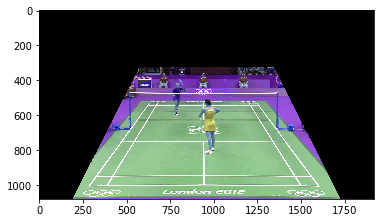

In [8]:
# crop one image
img = cv2.imread('./data/youtube_baun/img_08300.png')
img, mask = select_region(img)
plt.imshow(img)

# inference
poses, scores = pose_detector(img)

i = 0
unit_length = pose_detector.get_unit_length(poses[i])

# Flow-based Pose Track
前フレームのbboxを保持して比較したときに大きく変化した場合に処理を変える

In [54]:
def get_bbox_area(bbox):
    width = abs(bbox[0] - bbox[2])
    hight = abs(bbox[1] - bbox[3])
    area = width * hight
    return area

In [55]:
# for文でループを回す、一つ前のフレームは保持する
previous_bbox = []
for i in range(2):
    img = cv2.imread('./data/youtube_baun/img_0830{}.png'.format(i))
    play_region_img, mask = select_region(img)
    multi_person_poses, scores = pose_detector(play_region_img)
    print('img_0830{}: {} person in the image'.format(i, len(multi_person_poses)))
    pose_num = 0
    unit, limb_length = get_unit_length(multi_person_poses[pose_num])
    cropped_img, bbox = crop_person(img, multi_person_poses[pose_num], unit)
    
    # 最初のループは飛ばす
    if i == 0:
        print('skip {}th roop'.format(i))
        previous_bbox = list(bbox)
        cv2.imwrite('./data/cropped_images/cropimg_0830{}_pose{}.png'.format(i, pose_num), cropped_img)
        continue
        
    # 前フレームのbboxと比較して大きすぎたら前フレームのbboxを変化させるだけにする
    previous_bbox_area = get_bbox_area(previous_bbox)
    current_bbox_area = get_bbox_area(bbox)
    if (current_bbox_area > previous_bbox_area*2):
        cropped_img = pose_detecter.crop_image(img, previous_bbox)
    
    cv2.imwrite('./data/cropped_images/cropimg_0830{}_pose{}.png'.format(i, pose_num), cropped_img)

08300: 7 person in the image
skip 0th roop
08300: 7 person in the image


In [33]:
print('0830{}: {} person in the image'.format(0, len(multi_person_poses)))
unit, limb_length = get_unit_length(poses[0])
cropped_img, bbox = crop_person(img, poses[1], unit)

08300: 7 person in the image


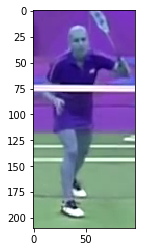

In [34]:
plt.imshow(cropped_img)

In [44]:
left_top_width = bbox[0]
left_top_hight = bbox[1]
right_bottom_width = bbox[2]
right_bottom_hight = bbox[3]
bbox

(750, 401, 848, 611)

In [41]:
hight = abs(right_bottom_hight - left_top_hight)
width = abs(right_bottom_width - left_top_width)
print(hight, width)

210 98


In [51]:
bx = []
if 

[]